In [170]:
!git pull upstream master --no-edit

remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 17 (delta 8), reused 17 (delta 8), pack-reused 0
Unpacking objects: 100% (17/17), done.
From https://github.com/CSSEGISandData/COVID-19
 * branch            master     -> FETCH_HEAD
   7798d34..a7f6c19  master     -> origin/master
Merge made by the 'recursive' strategy.
 .../csse_covid_19_daily_reports/03-24-2020.csv     | 3418 ++++++++++++++++++++
 .../time_series_covid19_confirmed_global.csv       |  481 +--
 .../time_series_covid19_deaths_global.csv          |  481 +--
 3 files changed, 3902 insertions(+), 478 deletions(-)
 create mode 100644 csse_covid_19_data/csse_covid_19_daily_reports/03-24-2020.csv


In [171]:
%matplotlib inline
from datetime import datetime
from datetime import timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set(font_scale=1.5)

In [285]:
def get_data():
    response = requests.get('https://coronadatascraper.com/timeseries.csv')
    data = io.StringIO(response.content.decode('utf-8'))
    df = pd.read_csv(data)
    df = df.select_dtypes(include=['float64']).fillna(0).join(df.select_dtypes(include=['object']).fillna(''))
    df['region'] = df.apply(lambda x: ', '.join(x[['city', 'county', 'state', 'country']]).strip(', '), axis=1)
    df['date'] = df['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    df = df.set_index(['region', 'date'])
    df = df[['cases', 'deaths', 'recovered', 'active', 'tested']].div(df['population'], axis=0)
    df.head()

cases  deaths     recovered        active  tested
region date                                                                
THA    2020-01-22  2.923372e-08     0.0  0.000000e+00  2.923372e-08     0.0
       2020-01-23  4.385059e-08     0.0  0.000000e+00  4.385059e-08     0.0
       2020-01-24  7.308431e-08     0.0  0.000000e+00  7.308431e-08     0.0
       2020-01-25  1.023180e-07     0.0  0.000000e+00  1.023180e-07     0.0
       2020-01-26  1.169349e-07     0.0  2.923372e-08  8.770117e-08     0.0

In [172]:
states = pd.read_excel('nst-est2019-01.xlsx', skiprows=3)
states.columns = ['Name' if i==0 else x for i, x in enumerate(states)]
states = states.rename(columns={2019: 'Population'})
states_pop = states.set_index('Name')[['Population']]
states_pop.index = states_pop.index.str.replace('.', '')
states_pop.head(10)

,Population
Name,
United States,328239523.0
Northeast,55982803.0
Midwest,68329004.0
South,125580448.0
West,78347268.0
Alabama,4903185.0
Alaska,731545.0
Arizona,7278717.0
Arkansas,3017804.0


In [173]:
country_pop = pd.read_csv('population-figures-by-country-csv_csv.csv').set_index('Country').iloc[:, -1:]
country_pop.columns = ['Population']
country_pop.head()

,Population
Country,
Aruba,104822.0
Afghanistan,34656032.0
Angola,28813463.0
Albania,2876101.0
Andorra,77281.0


In [174]:
confirmed = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
dates = [col for col in confirmed if '20' in col] # Get columns that have the year in them, i.e. the dates

In [175]:
def get_state_counts(normalize=True):
    import io
    import requests
    response = requests.get('http://covidtracking.com/api/states/daily.csv')
    data = io.StringIO(response.content.decode('utf-8'))
    df = pd.read_csv(data)
    df['state'] = [state_codes[x] for x in df['state']]
    df = df.join(states_pop, on='state', how='inner')
    cols = ['positive', 'negative', 'pending', 'hospitalized', 'death', 'total']
    if normalize:
        df[cols] = df[cols].fillna(0).div(df['Population'], axis=0)
    df['date'] = [datetime.strptime(str(x), '%Y%m%d') for x in df['date']]
    df = df.set_index(['state', 'date'])
    return df

state_codes = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [176]:
#def get_state_counts(counts):
#    counts_state = counts[counts['Country/Region']=='US'].set_index('Province/State').join(states_pop, how='inner')
#    counts_state = counts_state[dates].div(counts_state['Population'], axis=0)
#    return counts_state

state = get_state_counts(normalize=False)
hospitalized = state['hospitalized'].unstack('state').iloc[-1]
hospitalized = hospitalized[hospitalized.notnull()]
positive = state['positive'].unstack('state').iloc[-1].loc[hospitalized.index]
print("Hospitalizations per confirmed case = %.3g" % (hospitalized.sum() / positive.sum()))

state = get_state_counts()
confirmed_state = state['positive'].unstack('date').fillna(0)
deaths_state = state['death'].unstack('date').fillna(0)

Hospitalizations per confirmed case = 0.131


In [177]:
def get_country_counts(counts):
    df = counts[counts['Province/State'].isnull() | (counts['Province/State']==counts['Country/Region'])].set_index('Country/Region').join(country_pop, how='inner')
    df = df[dates].div(df['Population'], axis=0)
    df.columns = [datetime.strptime(x, '%m/%d/%y') for x in df.columns]
    return df

confirmed_country = get_country_counts(confirmed)
deaths_country = get_country_counts(deaths)

In [178]:
def make_merged(counts_state, counts_country, extrapolate=True):
    df = pd.concat([counts_state, counts_country])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # Ignore log(0) error
        df = np.log10(df)
    df.columns = [datetime.strptime(x, '%m/%d/%y') if isinstance(x, str) else x for x in df.columns]
    last = df.columns[-1]
    if df[last].isnull().mean() > 0.5:
        last = df.columns[-2]
    n_past = df.shape[1]
    df._last = last
    f = 0.5  # fraction of population susceptible
    T = 10  # days contagious
    r0 = 2.5
    k = r0/T
    c = np.log(f/(10**df[last]) - 1)/f
    for t in range(1, 101):
        day = last + timedelta(0, t*3600*24, 0)
        x = f*(1/(1+np.exp(f*(c-k*t))))
        df[day] = np.log10(x) if extrapolate else None
    return df
        
df_confirmed = make_merged(confirmed_state, confirmed_country)
df_d_confirmed = np.log10((10**df_confirmed).diff(periods=1, axis=1))
df_d_confirmed._last = df_confirmed._last + timedelta(0, 0*3600*24, 0)
df_deaths = make_merged(deaths_state, deaths_country, extrapolate=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in log10


In [179]:
def make_plot(df, label, start='2/28/20', places=['Arizona', 'New York', 'California', 'Spain', 'France', 'Italy', 'Maine'], ylim=(-7,0)):
    first = datetime.strptime(start, '%m/%d/%y')
    colors = ['r', 'g', 'b', 'k', 'c', 'orange', 'gold', 'blue', 'brown', 'purple']
    last = df._last
    ax = df.loc[places, :].loc[:, first:last].T.plot(figsize=(30, 10), linestyle='-', marker='o', color=colors[:len(places)])
    df.loc[places, :].loc[:, last:].T.plot(ax=ax, linestyle='--', legend=False, color=colors[:len(places)])
    tick_locs = df.columns[df.columns >= first]
    plt.xticks(tick_locs, [datetime.strftime(x, '%m/%d') for x in tick_locs], rotation=75);
    log_units = np.linspace(-6, 0, 7)
    plt.yticks(log_units, ['1 in %.0f' % (10.0**-x) for x in log_units]);
    plt.xlabel('Date')
    plt.ylabel('Number of residents per %s' % label);
    plt.ylim(-7, 0);

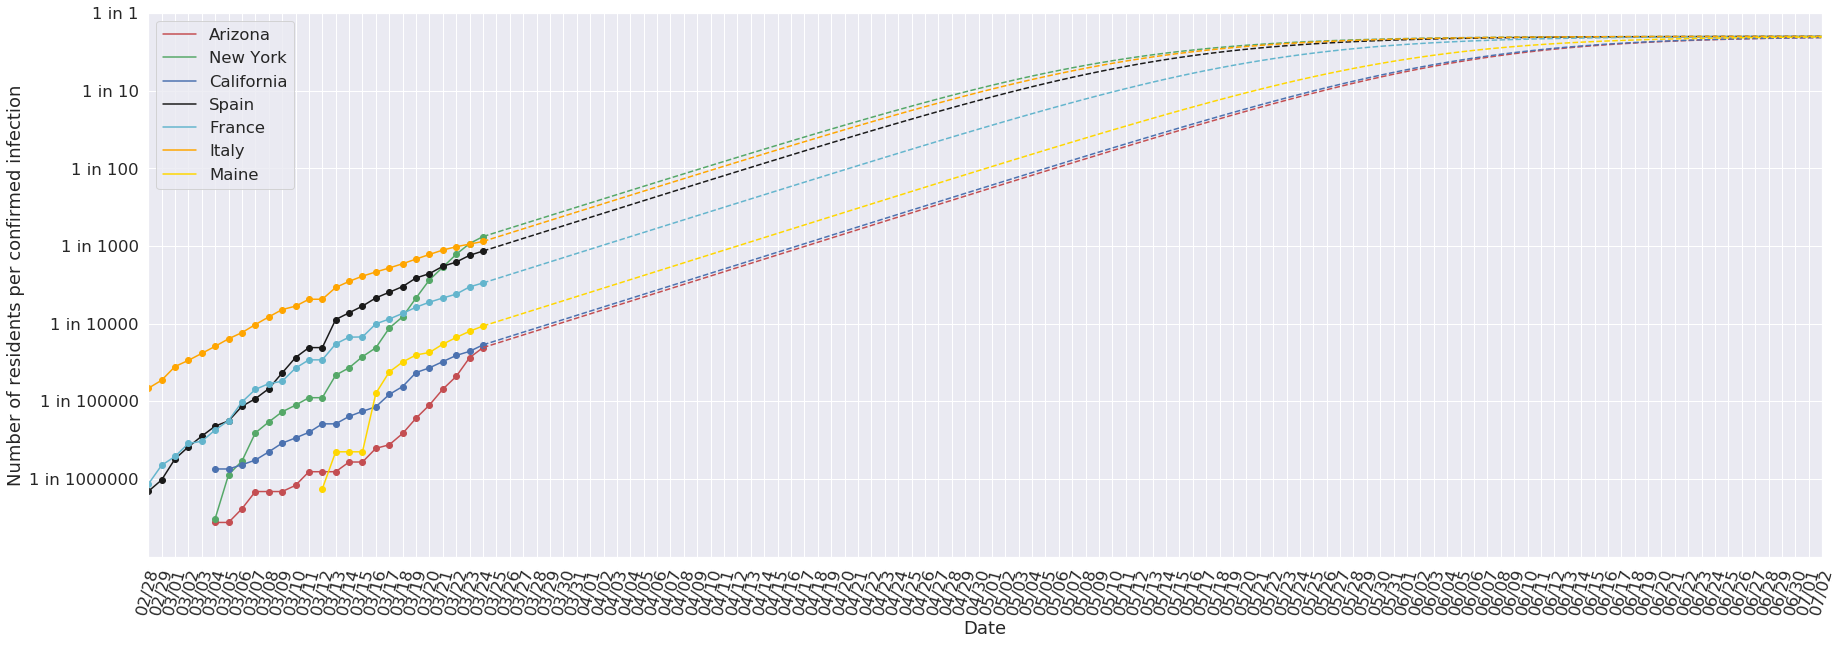

In [180]:
make_plot(df_confirmed, "confirmed infection")

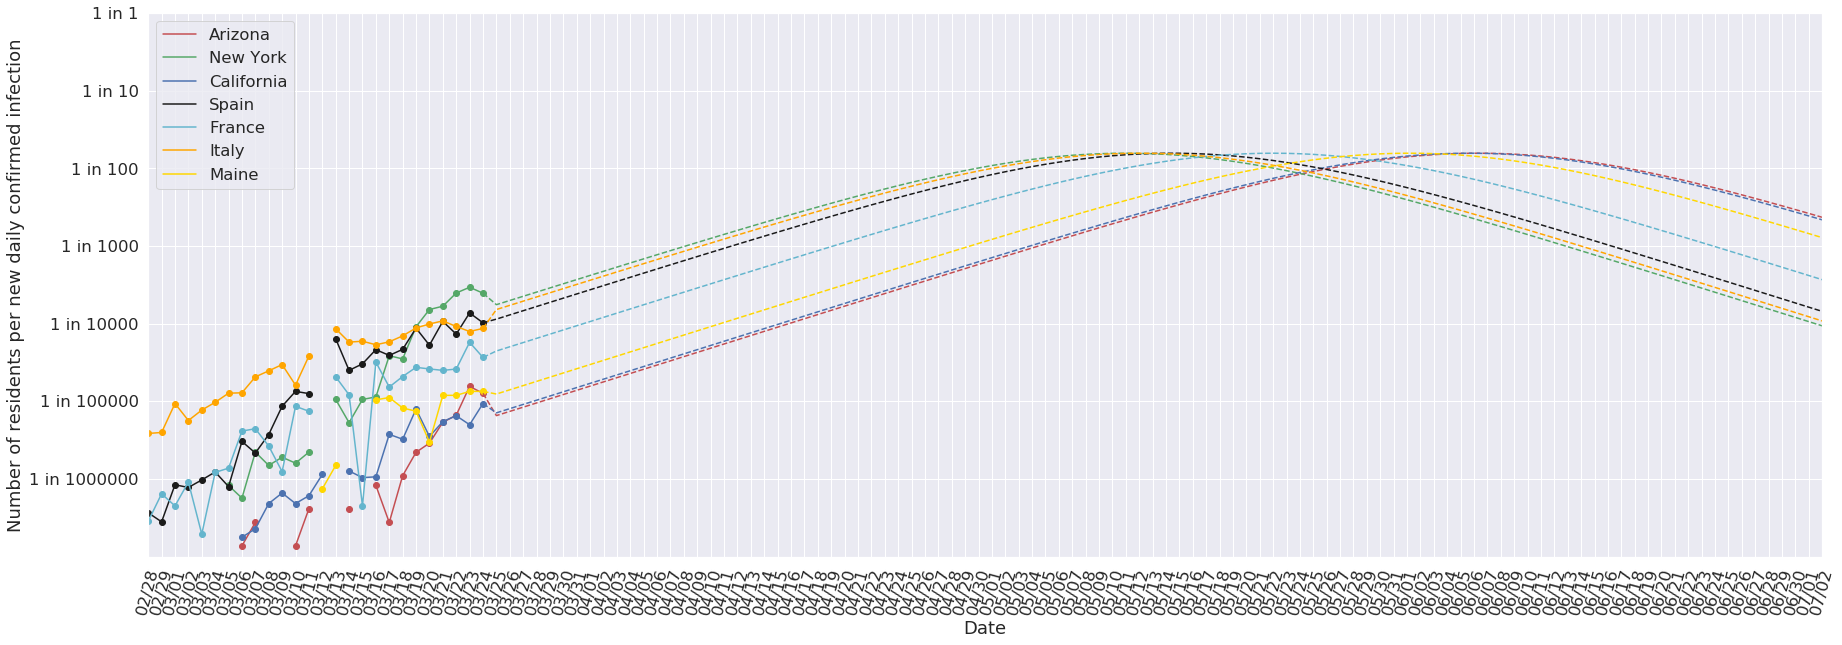

In [181]:
make_plot(df_d_confirmed, "new daily confirmed infection")

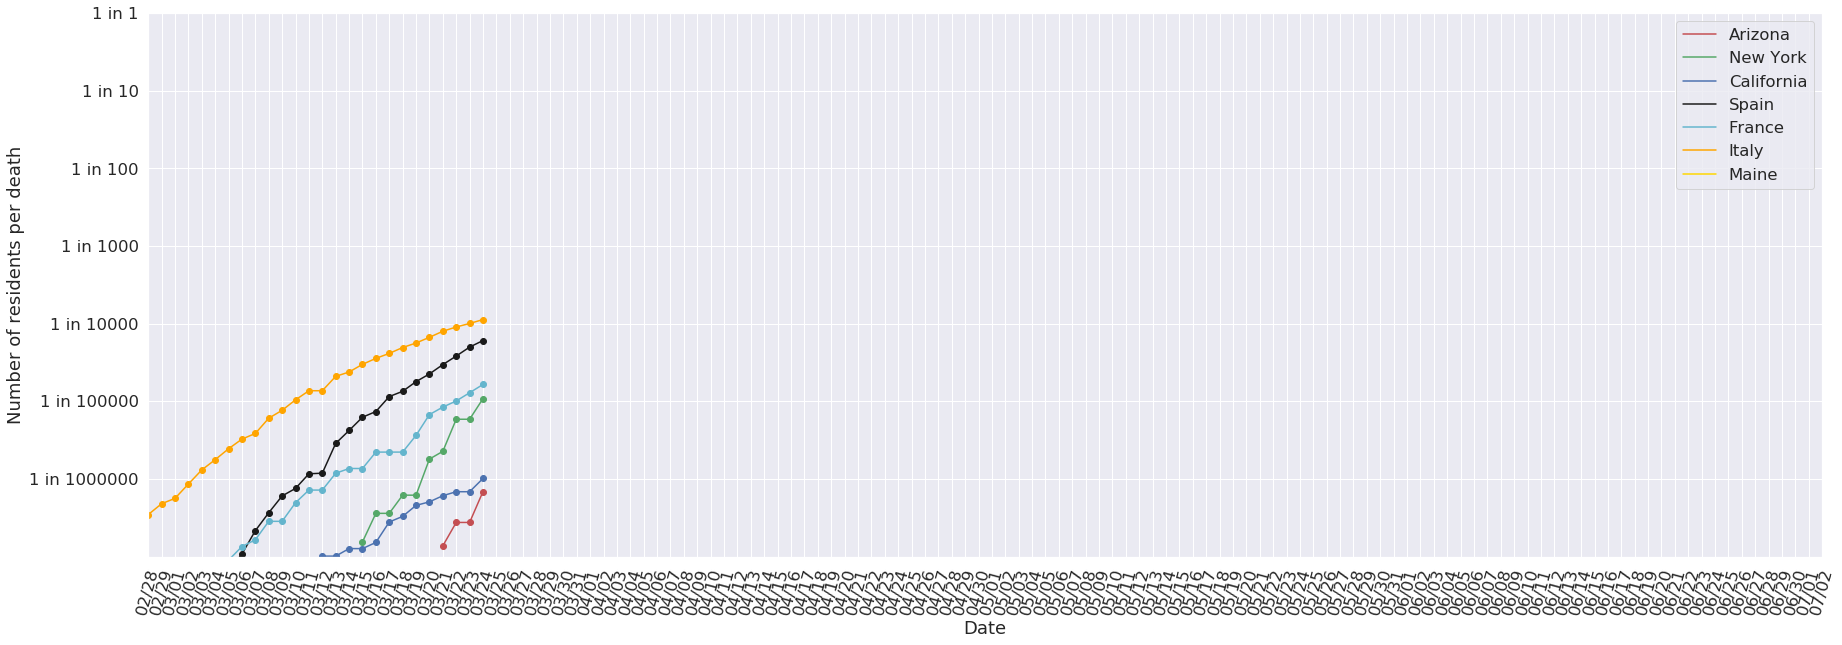

In [182]:
make_plot(df_deaths, "death", ylim=(-9,0))

(-8, 0)

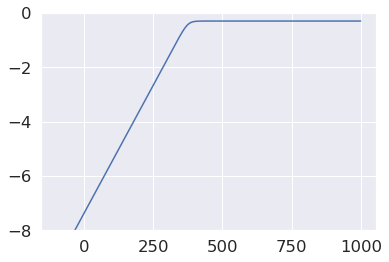

In [31]:
import numpy as np
f = 0.5
r = 0.2
c = 75
t = np.arange(-100, 1000, 1)
def xt(t, r, f, c):
    x = f*(1/(1+np.exp(f*(c-r*t))))
    return x
logx = np.log(f) - np.log10(1 + np.exp(f*(c-r*t)))
log10x = np.log10(np.exp(logx))
#plt.plot(t, 10**log10x);
#plt.ylim(0, f+0.01)
plt.plot(t, log10x);
plt.ylim(-8, 0)

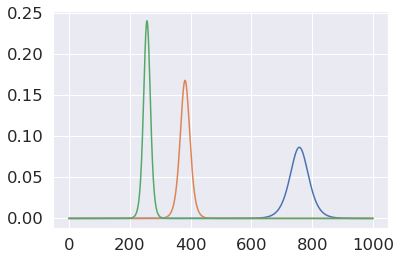

In [43]:
t = np.arange(0, 1000, 1)
T = 14
for r in [0.1, 0.2, 0.3]:
    y = xt(t, r) - xt(t-T, r)
    plt.plot(t, y)

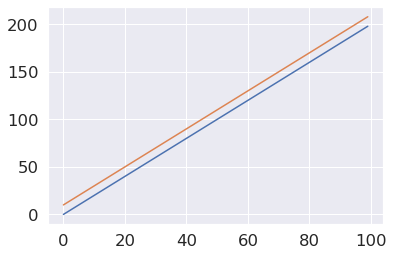

In [92]:
a = 10
r = 2
t = np.arange(0, 100, 1)
plt.plot(t, t*r)
plt.plot(t, a + t*r);

In [231]:
from neo.core import AnalogSignal
import quantities as pq
raw = np.zeros(10000)
cooked = AnalogSignal(raw, units=pq.V, sampling_rate=10*pq.kHz)

In [238]:
import sys
import inspect

def get_size(obj, seen=None):
    """Recursively finds size of objects in bytes"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if hasattr(obj, '__dict__'):
        for cls in obj.__class__.__mro__:
            if '__dict__' in cls.__dict__:
                d = cls.__dict__['__dict__']
                if inspect.isgetsetdescriptor(d) or inspect.ismemberdescriptor(d):
                    size += get_size(obj.__dict__, seen)
                break
    if isinstance(obj, dict):
        size += sum((get_size(v, seen) for v in obj.values()))
        size += sum((get_size(k, seen) for k in obj.keys()))
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        try:
            size += sum((get_size(i, seen) for i in obj))
        except:
            pass
        
    if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
        size += sum(get_size(getattr(obj, s), seen) for s in obj.__slots__ if hasattr(obj, s))
        
    return size

get_size(raw), get_size(cooked)

(309120, 19947)

In [237]:
sys.getsizeof(raw), sys.getsizeof(cooked.__dict__)

(80096, 160)